## 2.18 [Homework](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/02-regression/homework.md)

In [4]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2024-10-03 07:45:17--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv’

laptops.csv         100%[===================>] 291.58K  --.-KB/s    in 0.08s   

2024-10-03 07:45:17 (3.43 MB/s) - ‘laptops.csv’ saved [298573/298573]



In [9]:
import pandas as pd

df = (
    pd.read_csv("laptops.csv")
    .rename(columns=lambda x: x.lower().replace(' ', '_'))
    [["ram", "storage", "screen", "final_price"]]
)
df

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01
...,...,...,...,...
2155,16,1000,17.3,2699.99
2156,16,1000,17.3,2899.99
2157,32,1000,17.3,3399.99
2158,16,1000,13.4,1899.99


<Axes: xlabel='final_price', ylabel='Count'>

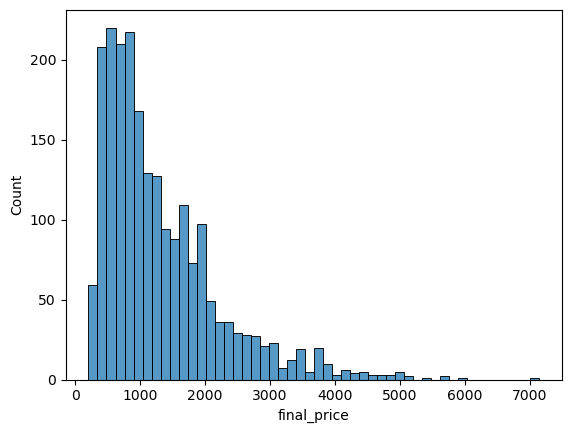

In [83]:
import seaborn as sns

sns.histplot(df.final_price, bins=50)

<Axes: xlabel='final_price', ylabel='Count'>

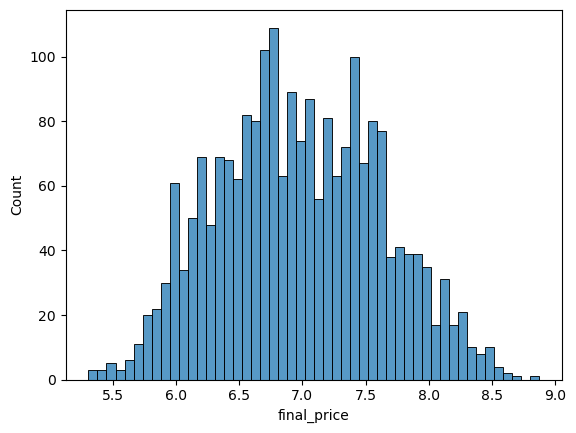

In [86]:
import numpy as np

sns.histplot(np.log1p(df.final_price), bins=50)

In [95]:
df.final_price = np.log1p(df.final_price)
df

,ram,storage,screen,final_price
0,8,512,15.6,6.917706
1,8,256,15.6,5.703782
2,8,256,15.6,6.672033
3,16,1000,15.6,7.090077
4,16,512,15.6,6.507293
...,...,...,...,...
2155,16,1000,17.3,7.901374
2156,16,1000,17.3,7.972807
2157,32,1000,17.3,8.131822
2158,16,1000,13.4,7.550130


## Q1

In [96]:
f"The column with missing values is: {df.columns[df.isna().sum(axis=0) > 0][0]}"

'The column with missing values is: screen'

## Q2

In [97]:
f"The median for 'ram' is: {df['ram'].median():.0f}"

"The median for 'ram' is: 16"

## Prepare and Split the Dataset

In [98]:
import numpy as np


def prep_X_y(fillna_method):
    """
    fillna_method can either be "mean" or 0
    """
    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(42)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    # Handle missing values in "screen"
    if fillna_method=="mean":
        df_train.loc[:, "screen"] = df_train.loc[:, "screen"].fillna(df_train["screen"].mean())
        df_val.loc[:, "screen"] = df_val.loc[:, "screen"].fillna(df_train["screen"].mean())
        df_test.loc[:, "screen"] = df_test.loc[:, "screen"].fillna(df_train["screen"].mean())
    elif fillna_method==0:
        df_train = df_train.fillna(0)
        df_val = df_val.fillna(0)
        df_test = df_test.fillna(0)

    X_train = df_train[["ram", "storage", "screen"]].values
    X_val = df_val[["ram", "storage", "screen"]].values
    X_test = df_test[["ram", "storage", "screen"]].values

    y_train = df_train["final_price"].values
    y_val = df_val["final_price"].values
    y_test = df_test["final_price"].values

    return (X_train, X_val, X_test, y_train, y_val, y_test)

## Q3

In [100]:
def train_linear_regression(X, y, r=0):
    """By default no regularization is applied. 
    Set r to nonzero value for regularization."""
    return np.linalg.inv(X.T @ X + r * np.eye(X.shape[1])) @ X.T @ y

def rmse(y, y_hat):
    return np.sqrt(((y_hat - y) ** 2).mean())

In [104]:
# fillna with 0
X_train, X_val, X_test, y_train, y_val, y_test = prep_X_y(0)
w = train_linear_regression(X_train, y_train)
y_hat_val = X_val @ w
print(f"RMSE for option to fill with 0 is: {round(rmse(np.expm1(y_val), np.expm1(y_hat_val)), 2)}")

# fillna with mean
X_train, X_val, X_test, y_train, y_val, y_test = prep_X_y("mean")
w = train_linear_regression(X_train, y_train)
y_hat_val = X_val @ w
print(f"RMSE for option to fill with mean is: {round(rmse(np.expm1(y_val), np.expm1(y_hat_val)), 2)}")


RMSE for option to fill with 0 is: 950.57
RMSE for option to fill with mean is: 903.0


## Q4

RMSE for 0: 950.57
RMSE for 0.01: 950.57
RMSE for 0.1: 950.58
RMSE for 1: 950.63
RMSE for 5: 950.86
RMSE for 10: 951.16
RMSE for 100: 956.47


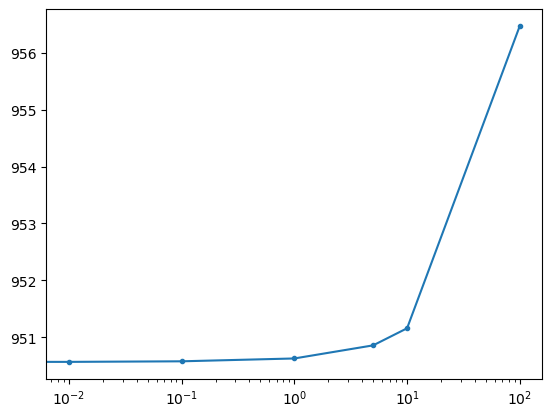

In [119]:
r_list = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_list = []

for r in r_list:
    X_train, X_val, X_test, y_train, y_val, y_test = prep_X_y(0)
    w = train_linear_regression(X_train, y_train, r)
    y_hat_val = X_val @ w
    rmse_list.append(round(rmse(np.expm1(y_val), np.expm1(y_hat_val)), 2))
    print(f"RMSE for {r}: {rmse_list[-1]}")

plt.plot(r_list, rmse_list, marker=".");
plt.xscale('log')

## Q5

## Q6